In [12]:
pip install tensorflow-addons[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import os
import random
import time
import IPython.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf
import tensorflow_addons as tfa

from math import ceil

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
class VizData():
    def __init__(self, data):
        self.data = data
        
    def plotfeatures(self, mode, title):
        features = self.data.columns.tolist()
        plot_features = self.data.groupby(pd.Grouper(freq=str(mode)+'T')).mean()
        plot_features = plot_features[features]
        plot_features.index = plot_features.index
        ncols = 2
        nrows = ceil(len(features)/ncols)
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10), facecolor="w", edgecolor="k")
        for i, feature in enumerate(features):
            axes[i // ncols, i % ncols].plot(plot_features[feature])
            axes[i // ncols, i % ncols].set_title(f'{feature} - {title}')     
        plt.tight_layout()
        plt.show()

    def plothist2d(self, feature):
        f = self.data.columns.tolist()
        features = [x for x in f if x != feature]
        ncols = 2
        nrows = ceil(len(features)/ncols)
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
        for i, feature_x in enumerate(features):
            if i == nrows * ncols - 2:
                ax = plt.subplot(nrows,1,ncols)
                counts, xedges, yedges, img = plt.hist2d(self.data[feature_x], self.data[feature], bins=(50, 50))
                ax.set_xlabel(f'{feature_x}')
                ax.set_ylabel(f'{feature}')
                ax.axis('tight')  
                plt.colorbar(img, ax=ax)
                plt.gca()
            else:
                ax = plt.subplot(nrows,ncols,i+1)
                counts, xedges, yedges, img = ax.hist2d(self.data[feature_x], self.data[feature], bins=(50, 50))
                ax.set_xlabel(f'{feature_x}')
                ax.set_ylabel(f'{feature}')
                ax.axis('tight')  
                plt.colorbar(img, ax=ax)
                plt.gca()
        plt.show()

    def plotbox(self, mode):
        plot_features = self.data.groupby(pd.Grouper(freq=str(60)+'T')).mean().copy()
        plot_features[mode] = [eval('x.%s'%mode) for x in plot_features.index] 
        plot_features.boxplot('wv (m/s)', by=mode, figsize=(12, 8), grid=False)
        plt.show()

In [57]:
weather = pd.read_csv("/content/drive/MyDrive/jena_weather_2004_2020.csv", parse_dates=True, index_col="Date Time")
weather.index.name = 'datetime'
weather = weather[[x for x in weather.columns if x != 'CO2 (ppm)']]

print("Size before cleaning data:", weather.shape)
weather = cleandata(data=weather)
print("Size after cleaning data:", weather.shape)

print("Size before filling data:", weather.shape)
#weather = filldata(weather)
weather = interpolatedata(weather)
print("Size after filling data:", weather.shape)

weather.head()

Size before cleaning data: (893974, 20)
Size after cleaning data: (892975, 20)
Size before filling data: (892975, 20)
==> 1595 rows have been filled <==
Size after filling data: (894240, 20)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),rain (mm),raining (s),SWDR (W/m²),PAR (µmol/m²/s),max. PAR (µmol/m²/s),Tlog (degC)
datetime,,,,,,,,,,,,,,,,,,,,
2004-01-01 00:10:00,996.82,-0.84,272.57,-1.23,97.2,5.74,5.58,0.16,3.49,5.60,1272.50,2.53,3.63,26.15,0.0,0.0,0.0,0.0,0.0,8.57
2004-01-01 00:20:00,996.69,-0.78,272.64,-1.22,96.8,5.77,5.59,0.18,3.49,5.60,1272.04,2.08,3.25,29.38,0.0,0.0,0.0,0.0,0.0,9.07
2004-01-01 00:30:00,996.69,-0.77,272.64,-1.29,96.3,5.77,5.56,0.21,3.48,5.58,1272.04,2.09,3.75,19.44,0.0,0.0,0.0,0.0,0.0,9.27
2004-01-01 00:40:00,996.67,-0.77,272.65,-1.39,95.6,5.77,5.52,0.25,3.45,5.54,1272.04,1.94,3.63,19.66,0.0,0.0,0.0,0.0,0.0,8.94
2004-01-01 00:50:00,996.52,-0.77,272.66,-1.44,95.2,5.77,5.49,0.28,3.44,5.51,1271.86,1.28,2.25,21.53,0.0,0.0,0.0,0.0,0.0,8.46


In [58]:
weather.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),894240.0,989.475921,8.639153,913.60,984.38,989.79,995.17,1020.07
T (degC),894240.0,9.679617,8.256389,-23.01,3.52,9.55,15.59,37.28
Tpot (K),894240.0,283.701809,8.359852,250.60,277.55,283.61,289.66,311.34
Tdew (degC),894240.0,4.993727,6.523026,-25.01,0.32,5.22,10.02,23.11
rh (%),894240.0,75.182544,16.800309,12.95,64.10,78.40,88.80,100.00
VPmax (mbar),894240.0,13.727357,7.746555,0.95,7.86,11.93,17.74,63.77
VPact (mbar),894240.0,9.513014,4.082564,0.79,6.25,8.87,12.31,28.32
VPdef (mbar),894240.0,4.214258,5.047451,0.00,0.95,2.28,5.51,47.81
sh (g/kg),894240.0,6.008240,2.592449,0.50,3.94,5.59,7.78,18.13
H2OC (mmol/mol),894240.0,9.617912,4.134115,0.80,6.32,8.96,12.45,28.82


In [59]:
usecols = ["T (degC)", "rh (%)", "p (mbar)", "wv (m/s)"]
weather = weather[usecols]
print("weather dataset shape:", weather.shape)

weather dataset shape: (894240, 4)


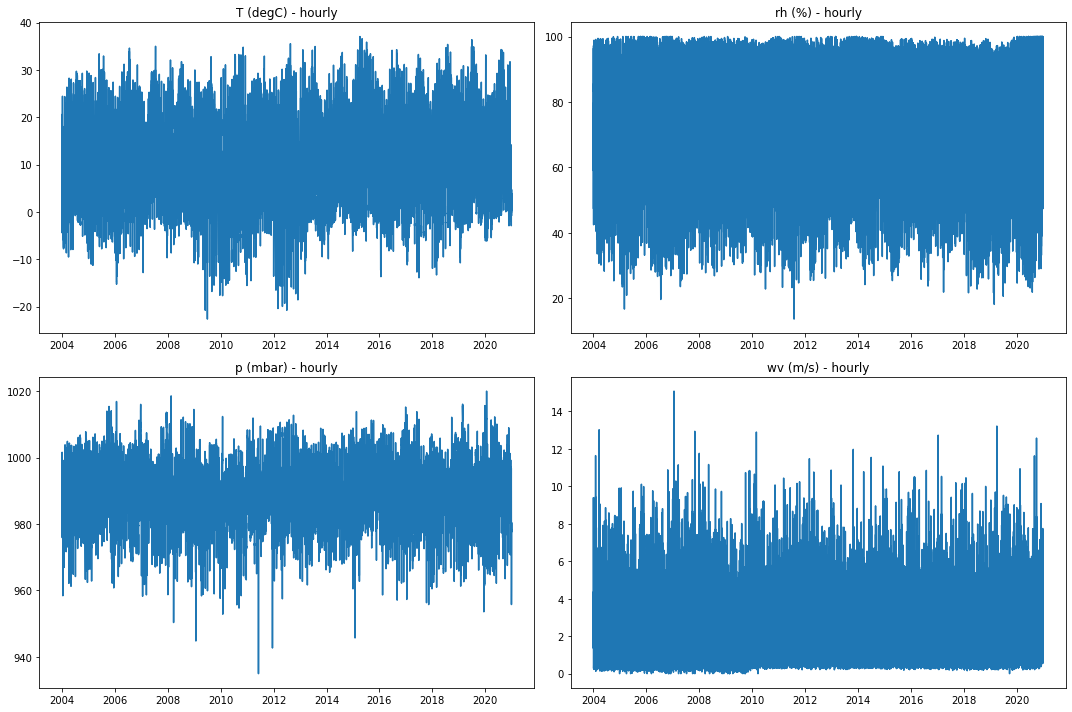

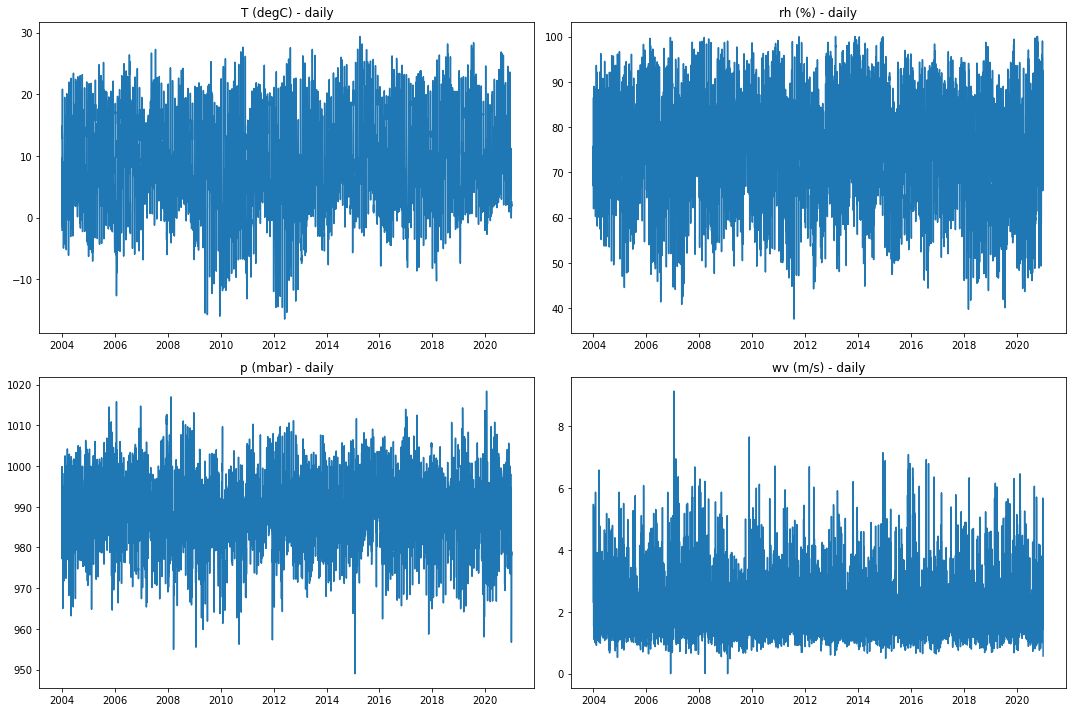

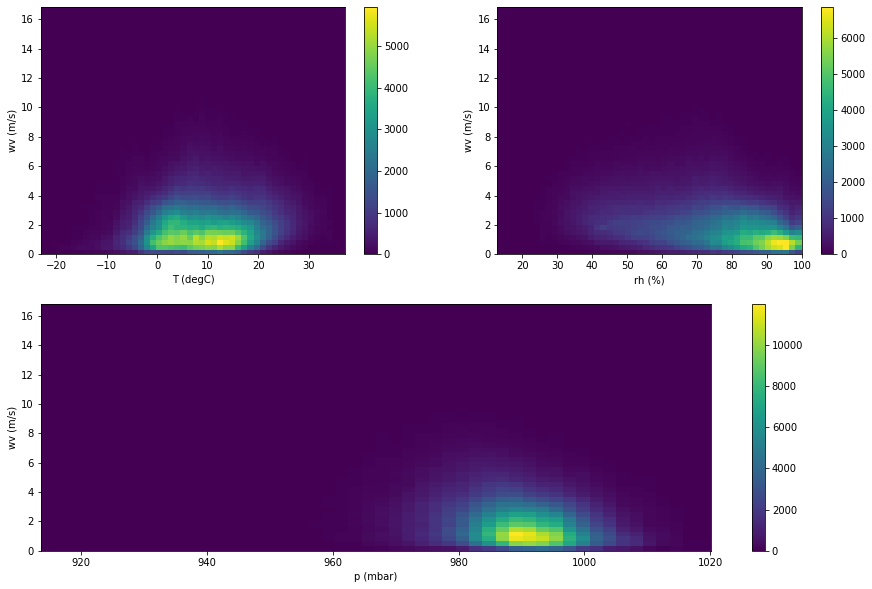

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


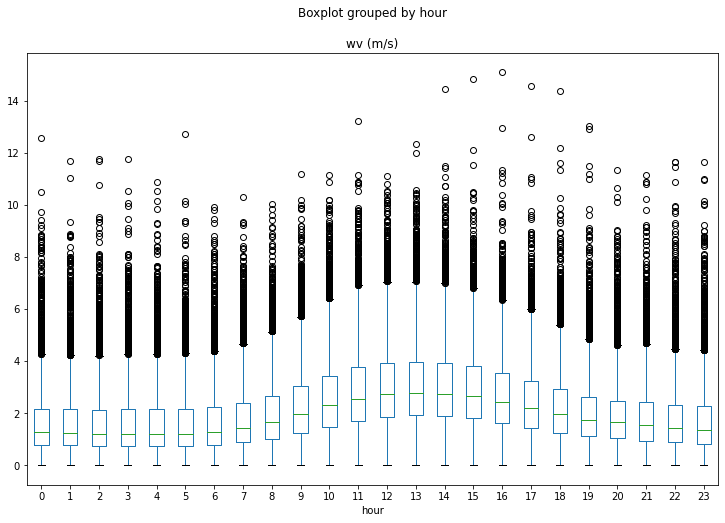

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


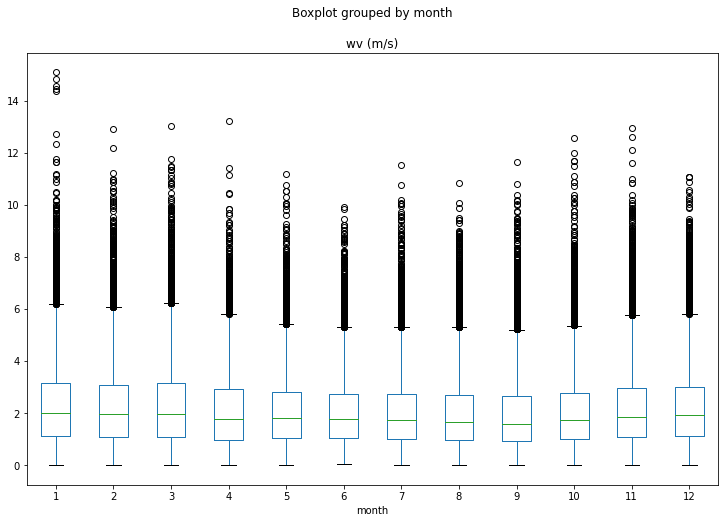

In [60]:
vd = VizData(data=weather)
vd.plotfeatures(mode=60, title="hourly")
vd.plotfeatures(mode=60*24, title="daily")
vd.plothist2d(feature="wv (m/s)")
vd.plotbox(mode="hour")
vd.plotbox(mode="month")

In [20]:
class DataPreprocessing():
    def __init__(self, data, sampling_window, **kwargs):
        self.data = data
        self.sampling_window = sampling_window
        self.trainsize = kwargs.get('trainsize', 0.7)
        self.valsize = kwargs.get('valsize', 0.2)

    def datasplit(self, **kwargs):
        self.addcyclics = kwargs.get('addcyclics', False)
        self.normalize = kwargs.get('normalize', None)
        self.features = kwargs.get('features', None)
        
        self.resample_data = self.data.resample(str(self.sampling_window)+'T').mean()
        
        if self.resample_data.isna().sum().sum() > 0:
            raise Exception(f"Oops! there are some NaN values in resampled data.")

        if self.features is not None:
            self.resample_data = self.resample_data[self.features]
        if self.addcyclics:
            self.resample_data = self.__class__.cyclical(self.resample_data)   
            self.features = self.resample_data.columns
        
        self.train_df = self.resample_data[0:int(len(self.resample_data)*self.trainsize)]
        self.val_df = self.resample_data[int(len(self.resample_data)*self.trainsize):int(len(self.resample_data)*(self.trainsize+self.valsize))]
        self.test_df = self.resample_data[int(len(self.resample_data)*(self.trainsize+self.valsize)):]
                
        if self.normalize is not None:
            if self.normalize == 'MinMaxScaler':
                self.scaler = MinMaxScaler(feature_range=(0, 1))
            elif self.normalize == 'StandardScaler':
                self.scaler = StandardScaler()
            # normalizing input features
            self.train_df = pd.DataFrame(self.scaler.fit_transform(self.train_df), columns=self.train_df.columns, index=self.train_df.index)
            self.val_df = pd.DataFrame(self.scaler.transform(self.val_df), columns=self.val_df.columns, index=self.val_df.index)
            self.test_df = pd.DataFrame(self.scaler.transform(self.test_df), columns=self.test_df.columns, index=self.test_df.index)
            
        return self.train_df, self.val_df, self.test_df
    
    @staticmethod
    def cyclical(data):
        data = data.copy()
        # Extracting the hour of day
        data["hour"] = [x.hour for x in data.index]
        # Creating the cyclical daily feature 
        data["day_cos"] = [np.cos(x * (2 * np.pi / 24)) for x in data["hour"]]
        data["day_sin"] = [np.sin(x * (2 * np.pi / 24)) for x in data["hour"]]
        # Extracting the timestamp from the datetime object 
        data["timestamp"] = [x.timestamp() for x in data.index]
        # Seconds in day 
        s = 24 * 60 * 60
        # Seconds in year 
        year = (365.25) * s
        data["month_cos"] = [np.cos((x) * (2 * np.pi / year)) for x in data["timestamp"]]
        data["month_sin"] = [np.sin((x) * (2 * np.pi / year)) for x in data["timestamp"]]
        data = data.drop(['hour', 'timestamp'], axis=1)
        return data

In [21]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 batch_size, sequence_stride,
                 train_df, val_df, test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.sequence_stride = sequence_stride

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
            self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift + label_width

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.input_width + self.shift
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Offset: {self.shift}',
            f'Label column name(s): {self.label_columns}',
        ])
  
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels
    def make_dataset(self, data, sequence_stride):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=sequence_stride, 
            shuffle=False,
            batch_size=self.batch_size,
        )
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df, self.sequence_stride)
    @property
    def val(self):
        return self.make_dataset(self.val_df, self.sequence_stride)
    @property
    def test(self):
        return self.make_dataset(self.test_df, self.sequence_stride)
    
    @property
    def flattrain(self):
        return self.make_dataset(self.train_df, self.label_width)
    @property
    def flatval(self):
        return self.make_dataset(self.val_df, self.label_width)
    @property
    def flattest(self):
        return self.make_dataset(self.test_df, self.label_width)
 
    def randomplots(self, mc=None, max_subplots=3, **kwargs):   
        plot_col = kwargs.get('plot_col', self.label_columns[0])

        real_x = np.concatenate(list(map(lambda x: x[0].numpy(), self.flattest)))
        real_y = np.concatenate(list(map(lambda x: x[1].numpy(), self.flattest))) 

        plot_col_index = self.column_indices[plot_col]
        indexes = random.sample(range(len(real_x)), max_subplots)

        if mc is not None:
            reshape_real_x = mc.reshape(real_x)
            max_subplots = max_subplots + 1

        plt.figure(figsize=(12, 8))
        for n in range(max_subplots):
            plt.subplot(max_subplots, 1, n+1)
            if n == max_subplots - 1 and mc is not None: 
                plt.plot(real_y[:, :, label_col_index].reshape(-1, 1))
                plt.plot(predictions.reshape(-1, 1))

            else: 
                plt.plot(self.input_indices, real_x[indexes[n], :, plot_col_index], 
                         label='Inputs', marker='.', zorder=-10)

                if self.label_columns:
                    label_col_index = self.label_columns_indices.get(plot_col, None)
                else:
                    label_col_index = plot_col_index

                if label_col_index is None:
                    continue

                plt.scatter(self.label_indices, real_y[indexes[n], :, label_col_index], 
                            marker='p', edgecolors='k', label='Labels', 
                            c='#2ca02c', s=64)
                if mc is not None:
                    predictions = mc.model.predict(reshape_real_x)
                    plt.scatter(self.label_indices, predictions[indexes[n], :], 
                                marker='*', edgecolors='k', label='Predictions',
                                c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()
                plt.title(f'{plot_col} [scaled]')
        plt.xlabel('Timesteps')
        
    def plotforecast(self, mc, title, **kwargs):
        withinputs = kwargs.get('withinputs', False)
        windows = kwargs.get('windows', None)
        labels = ["Actual values", "Predicted values"]

        real_x = np.concatenate(list(map(lambda x: x[0].numpy(), self.flattest)))
        real_y = np.concatenate(list(map(lambda x: x[1].numpy(), self.flattest)))
        pred_y = mc.model.predict(mc.reshape(real_x))

        real_y = real_y.reshape(-1, 1)
        pred_y = pred_y.reshape(-1, 1)

        plt.figure(figsize=(15,5))
        if withinputs:
            plt.plot(self.test_df[self.label_columns].values[:self.input_width+len(pred_y[:windows])], label=labels[0])
            plt.plot(np.arange(self.input_width, self.input_width+len(pred_y[:windows])), pred_y[:windows], label=labels[1])
        else:
            plt.plot(real_y[:windows], label=labels[0])
            plt.plot(pred_y[:windows], label=labels[1])
        plt.title(f'{title}: {self.input_width} previous timesteps-based {self.label_width} future timesteps forecasting')
        plt.xlabel("Test dataset points")
        plt.legend(frameon=False)
        plt.show()

In [22]:
class ModelingClass():
    def __init__(self, mapdataset, epochs, patience, learning_rate, loss, metrics, verbose=1):
        self.mapdataset = mapdataset
        self.epochs = epochs
        self.patience = patience
        self.learning_rate = learning_rate
        self.verbose = verbose
        self.loss = loss 
        self.metrics = metrics
        self.label_feature_number = list(map(lambda x: x[1].numpy(), mapdataset.train.take(1)))[0].shape[2]
 
    def reshape(self, data):
        return data
    # build the model
    def modelbuild(self):
        # define model
        model = None
        return model
        
    def traincallback(self):
        # simple early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=self.patience, verbose=1)
        return early_stopping 
    
    # train the model
    def train(self):
        # Building the model
        self.model = self.modelbuild()
        # Initiating the optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Instantiate an optimizer before passing it to model.compile() or pass it by its string identifier.
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        # fit network
        if (self.mapdataset.val is not None):
            self.history = self.model.fit(
                self.mapdataset.train,
                validation_data=self.mapdataset.val,    
                epochs=self.epochs, 
                verbose=self.verbose, 
                shuffle=False,
                callbacks=[self.traincallback()],
            )
        else:
            self.history = self.model.fit(
                self.mapdataset.train,    
                epochs=self.epochs, 
                verbose=self.verbose, 
                shuffle=False,
                callbacks=[self.traincallback()],
            )
        return self.history
    
    def computemetrics(self, mapdata): 
        real_y = np.concatenate(list(map(lambda x: x[1].numpy(), mapdata)))
        real_y = real_y.reshape(real_y.shape[0], real_y.shape[1])
        pred_y = self.model.predict(mapdata)
        pred_y = pred_y.reshape(pred_y.shape[0], pred_y.shape[1])

        RMSE = mean_squared_error(real_y, pred_y, squared=False)
        MSE = mean_squared_error(real_y, pred_y)
        MAE = mean_absolute_error(real_y, pred_y)
        MAPE = 100*mean_absolute_percentage_error(real_y, pred_y)
        R2 = r2_score(real_y, pred_y)   
        # calculate the metric score for each timestep
        rmse_scores = mean_squared_error(real_y, pred_y, multioutput='raw_values', squared=False)
        mse_scores = mean_squared_error(real_y, pred_y, multioutput='raw_values')
        mae_scores = mean_absolute_error(real_y, pred_y, multioutput='raw_values')
        mape_scores = 100*mean_absolute_percentage_error(real_y, pred_y, multioutput='raw_values')
        r2_scores = r2_score(real_y, pred_y, multioutput='raw_values')
        print('rmse: %.4f [%s]' %(RMSE, ', '.join(['%.4f' % s for s in rmse_scores])))
        print('mse : %.4f [%s]' %(MSE, ', '.join(['%.4f' % s for s in mse_scores])))
        print('mae : %.4f [%s]' %(MAE, ', '.join(['%.4f' % s for s in mae_scores])))
        print('mape: %.4f [%s]' %(MAPE, ', '.join(['%.4f' % s for s in mape_scores])))
        print('r2  : %.4f [%s]' %(R2, ', '.join(['%.4f' % s for s in r2_scores])))
    
    @property
    def trainmetrics(self):
        return self.computemetrics(self.mapdataset.train)
    @property
    def valmetrics(self):
        return self.computemetrics(self.mapdataset.val)
    @property
    def testmetrics(self):
        return self.computemetrics(self.mapdataset.test)
    def lossplot(self, **kwargs):
        if len(self.model.metrics_names) <= 2:
            l, c = 1, 2
        else:
            l, c = (len(self.model.metrics_names)//2)+1, 2
        title = kwargs.get('title', "")
        epochs = range(len(self.history.history[self.model.metrics_names[0]]))
        plt.figure(figsize=(15,3.5*l))
        for i in range(len(self.model.metrics_names)):
            plt.subplot(l,c,i+1)
            if self.model.metrics_names[i] == "loss":
                plt.plot(epochs, self.history.history[self.model.metrics_names[i]], "b", label="Training "+self.loss[0]+'*')
                plt.plot(epochs, self.history.history["val_"+self.model.metrics_names[i]], "green", label="Validation "+"val_"+self.loss[0]+'*')
                plt.xlabel("Epochs")
                plt.ylabel(self.loss[0]+'*')
                plt.legend(frameon=False)
            else:
                plt.plot(epochs, self.history.history[self.model.metrics_names[i]], "b", label="Training "+self.model.metrics_names[i])
                plt.plot(epochs, self.history.history["val_"+self.model.metrics_names[i]], "green", label="Validation "+"val_"+self.model.metrics_names[i])
                plt.xlabel("Epochs")
                plt.ylabel(self.model.metrics_names[i])
                plt.legend(frameon=False)
        plt.suptitle("Training and validation losses: {}".format(title))
        plt.subplots_adjust(hspace=0.4)
        plt.show()
    
    def modelevaluate(self, train_performance, val_performance, test_performance):
        for x in ["train", "val", "test"]:
            print("\nModel evaluation on %s dataset:\n"%x)
            eval("%s_performance"%x)[self.__class__.__name__] = self.model.evaluate(eval("self.mapdataset.%s"%x))
            print(list(map(lambda x: round(x, 4), eval("%s_performance"%x)[self.__class__.__name__])))
        return train_performance, val_performance, test_performance

In [46]:
sampling_window = 60
addcyclics = False
normalize = True
#normalize_type = "StandardScaler"
normalize_type = "MinMaxScaler"

n_input, n_output = 48, 7 #48, 7
sequence_stride = 1 
epochs, batch_size, learning_rate, patience = 150, 2**7, 0.001, 10 #150, 2**7, 0.001, 10
loss, metrics = ['mse'], ['mae', 'mape', tfa.metrics.RSquare(name='r2', dtype=tf.float32, num_regressors=n_output)] 

features = ["p (mbar)", "T (degC)", "rh (%)", "wv (m/s)"]

train_performance = {}
val_performance = {}
test_performance = {}

In [24]:
def run(data, modelingclassname, title, train_performance, val_performance, test_performance):
    
    start = time.time()
    
    dp = DataPreprocessing(data=data, sampling_window=sampling_window, trainsize=0.7, valsize=0.2)
    train_df, val_df, test_df = dp.datasplit(features=features, addcyclics=addcyclics, normalize=normalize_type)

    mw = WindowGenerator(
        train_df=train_df, 
        val_df=val_df, 
        test_df=test_df,
        input_width=n_input,
        label_width=n_output,
        shift=0,
        label_columns=['wv (m/s)'],
        batch_size=batch_size,
        sequence_stride=sequence_stride,
    )       
        
    mc = modelingclassname(
        mapdataset=mw,
        epochs=epochs,
        patience=patience,
        learning_rate=learning_rate,
        loss=loss, 
        metrics=metrics)

    history = mc.train()
    
    IPython.display.clear_output()
    
    print(mw)
    
    for example_inputs, example_labels in mw.train.take(1):
    #for example_inputs, example_labels in mw.train:
        print(f'\nInput shape (batch size, timesteps, features): {example_inputs.shape}')
        print(f'Label shape (batch size, timesteps, features): {example_labels.shape}\n')

    display(tf.keras.utils.plot_model(mc.model, mc.__class__.__name__+"_model_with_shape_info.png", show_shapes=True, show_layer_names=True))
        
    train_performance, val_performance, test_performance = mc.modelevaluate(train_performance, val_performance, test_performance)
        
    print("\nModeling metrics on train data set:\n")
    mc.trainmetrics
    print("\nModeling metrics on validation data set:\n")
    mc.valmetrics
    print("\nModeling metrics on test data set:\n")
    mc.testmetrics

    mc.lossplot(title=title)
 
    mw.randomplots(mc)

    mw.plotforecast(mc, title=title, windows=500, withinputs=True)
    
    print("Time taken with the %s model: %.2f sec" %(mc.__class__.__name__, time.time()-start))
    
    return dp, mw, mc, train_performance, val_performance, test_performance

RNN Model

In [47]:
class RNN(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model        
        model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, lstm_units]
            # Adding more `lstm_units` just overfits more quickly.
            tf.keras.layers.SimpleRNN(32, return_sequences=False),
            # Shape => [batch, out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)



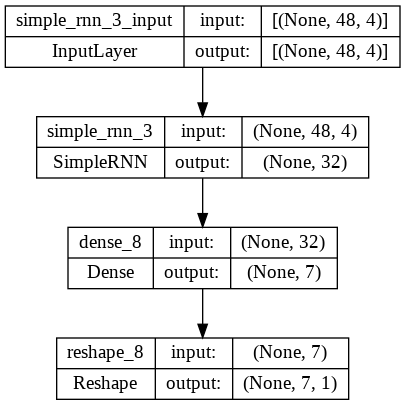


Model evaluation on train dataset:

815/815 [==============================] - 11s 14ms/step - loss: 0.0053 - mae: 0.0527 - mape: 115676.6484 - r2: 0.4692
[0.0053, 0.0527, 115676.6484, 0.4692]

Model evaluation on val dataset:

233/233 [==============================] - 3s 14ms/step - loss: 0.0049 - mae: 0.0509 - mape: 55.1786 - r2: 0.4894
[0.0049, 0.0509, 55.1786, 0.4894]

Model evaluation on test dataset:

117/117 [==============================] - 2s 19ms/step - loss: 0.0051 - mae: 0.0516 - mape: 49790.5820 - r2: 0.4910
[0.0051, 0.0516, 49790.582, 0.491]

Modeling metrics on train data set:

815/815 [==============================] - 11s 14ms/step
rmse: 0.0719 [0.0476, 0.0622, 0.0702, 0.0758, 0.0799, 0.0828, 0.0851]
mse : 0.0053 [0.0023, 0.0039, 0.0049, 0.0057, 0.0064, 0.0069, 0.0072]
mae : 0.0527 [0.0341, 0.0450, 0.0510, 0.0554, 0.0587, 0.0612, 0.0632]
mape: 52069610291200.0000 [17600117473280.0000, 31161797574656.0000, 42927984214016.0000, 54099504529408.0000, 64435787923456.0000

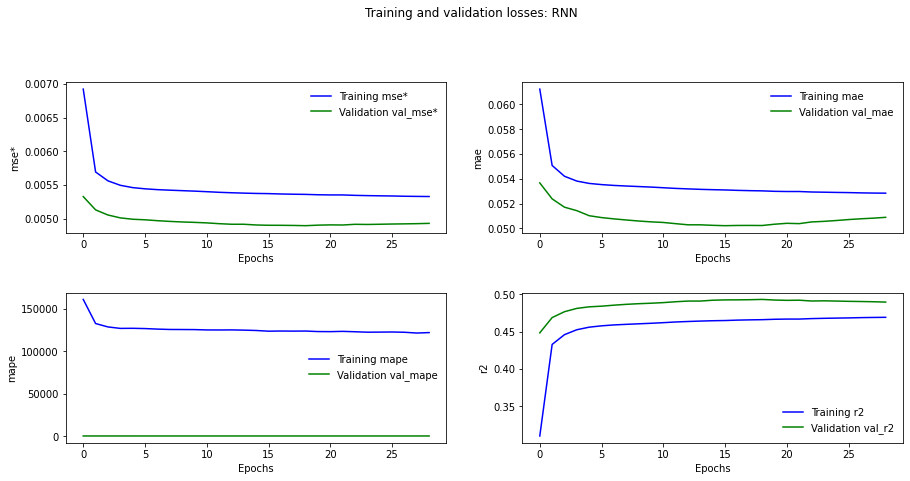

67/67 [==============================] - 0s 3ms/step


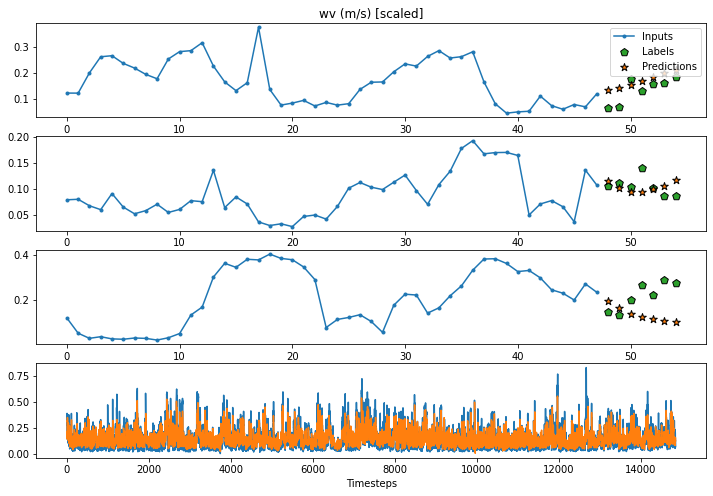

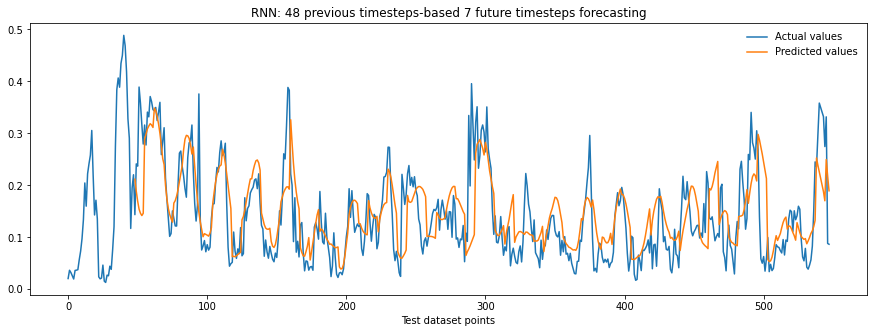

Time taken with the RNN model: 613.49 sec


In [48]:
dp_rnn, mw_rnn, mc_rnn, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=RNN, title="RNN", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

LSTM model

In [49]:
class LSTM(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model        
        model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, lstm_units]
            # Adding more `lstm_units` just overfits more quickly.
            tf.keras.layers.LSTM(32, return_sequences=False),
            # Shape => [batch, out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)



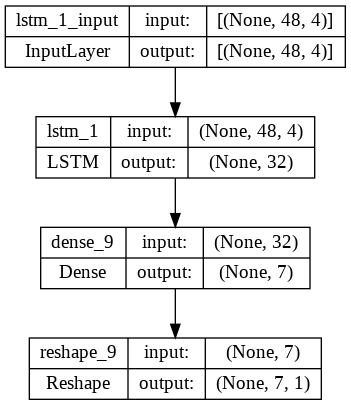


Model evaluation on train dataset:

815/815 [==============================] - 15s 18ms/step - loss: 0.0050 - mae: 0.0510 - mape: 107266.0469 - r2: 0.5035
[0.005, 0.051, 107266.0469, 0.5035]

Model evaluation on val dataset:

233/233 [==============================] - 4s 18ms/step - loss: 0.0047 - mae: 0.0496 - mape: 52.9197 - r2: 0.5084
[0.0047, 0.0496, 52.9197, 0.5084]

Model evaluation on test dataset:

117/117 [==============================] - 2s 17ms/step - loss: 0.0049 - mae: 0.0503 - mape: 47815.4414 - r2: 0.5104
[0.0049, 0.0503, 47815.4414, 0.5104]

Modeling metrics on train data set:

815/815 [==============================] - 15s 18ms/step
rmse: 0.0697 [0.0469, 0.0608, 0.0681, 0.0732, 0.0769, 0.0797, 0.0820]
mse : 0.0050 [0.0022, 0.0037, 0.0046, 0.0054, 0.0059, 0.0064, 0.0067]
mae : 0.0510 [0.0334, 0.0437, 0.0495, 0.0537, 0.0567, 0.0591, 0.0609]
mape: 48283090944000.0000 [16201778462720.0000, 30390957899776.0000, 42456498307072.0000, 51818121920512.0000, 59579610169344.0000

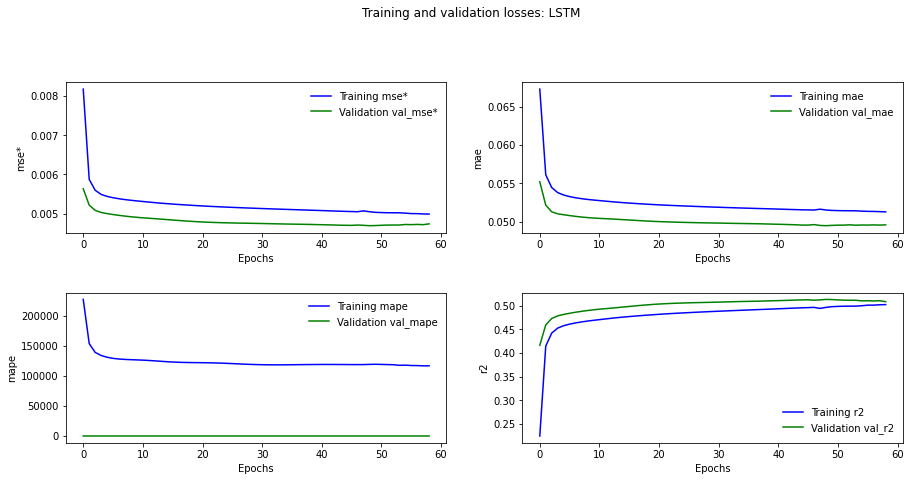

67/67 [==============================] - 0s 5ms/step


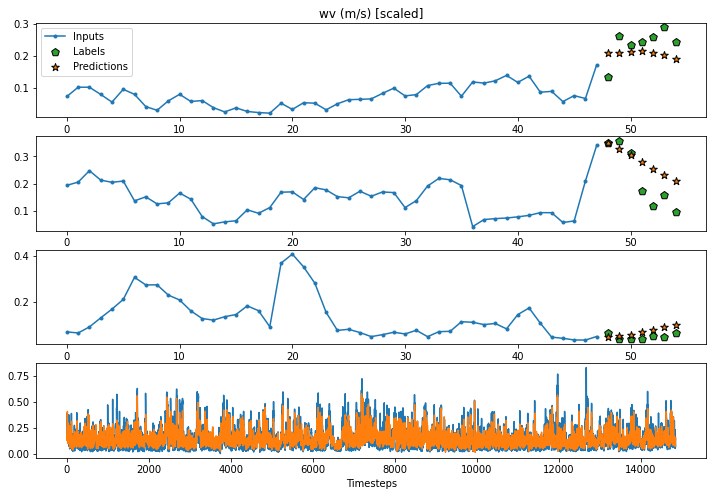

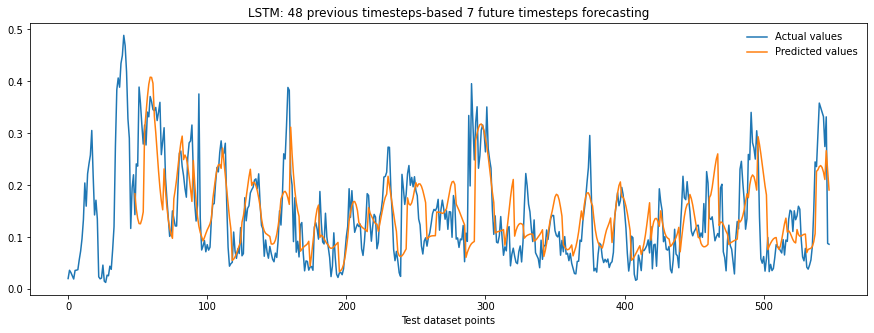

Time taken with the LSTM model: 2209.70 sec


In [50]:
dp_lstm, mw_lstm, mc_lstm, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=LSTM, title="LSTM", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)

GRU model

In [51]:
class GRU(ModelingClass):
    # build the model
    def modelbuild(self):
        # define model        
        model = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, lstm_units]
            # Adding more `lstm_units` just overfits more quickly.
            tf.keras.layers.GRU(32, return_sequences=False),
            # Shape => [batch, out_steps*features]
            tf.keras.layers.Dense(self.mapdataset.label_width*self.label_feature_number, kernel_initializer=tf.initializers.zeros),
            # Shape => [batch, out_steps, features]
            tf.keras.layers.Reshape([self.mapdataset.label_width, self.label_feature_number])
        ])
        return model

Total window size: 55
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label indices: [48 49 50 51 52 53 54]
Offset: 0
Label column name(s): ['wv (m/s)']

Input shape (batch size, timesteps, features): (128, 48, 4)
Label shape (batch size, timesteps, features): (128, 7, 1)



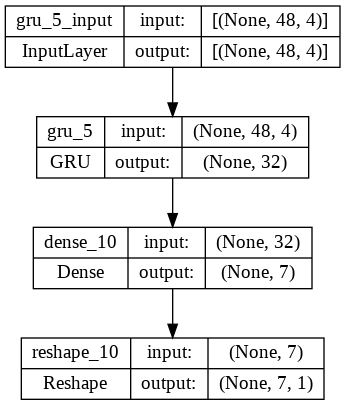


Model evaluation on train dataset:

815/815 [==============================] - 12s 14ms/step - loss: 0.0050 - mae: 0.0509 - mape: 106386.8516 - r2: 0.5053
[0.005, 0.0509, 106386.8516, 0.5053]

Model evaluation on val dataset:

233/233 [==============================] - 5s 22ms/step - loss: 0.0048 - mae: 0.0495 - mape: 52.4837 - r2: 0.5067
[0.0048, 0.0495, 52.4837, 0.5067]

Model evaluation on test dataset:

117/117 [==============================] - 2s 14ms/step - loss: 0.0048 - mae: 0.0499 - mape: 49827.7539 - r2: 0.5189
[0.0048, 0.0499, 49827.7539, 0.5189]

Modeling metrics on train data set:

815/815 [==============================] - 12s 14ms/step
rmse: 0.0696 [0.0472, 0.0608, 0.0680, 0.0730, 0.0767, 0.0795, 0.0817]
mse : 0.0050 [0.0022, 0.0037, 0.0046, 0.0053, 0.0059, 0.0063, 0.0067]
mae : 0.0509 [0.0338, 0.0439, 0.0494, 0.0534, 0.0563, 0.0586, 0.0605]
mape: 47887224012800.0000 [17074519801856.0000, 30606914224128.0000, 41944252153856.0000, 50669746651136.0000, 58340063313920.000

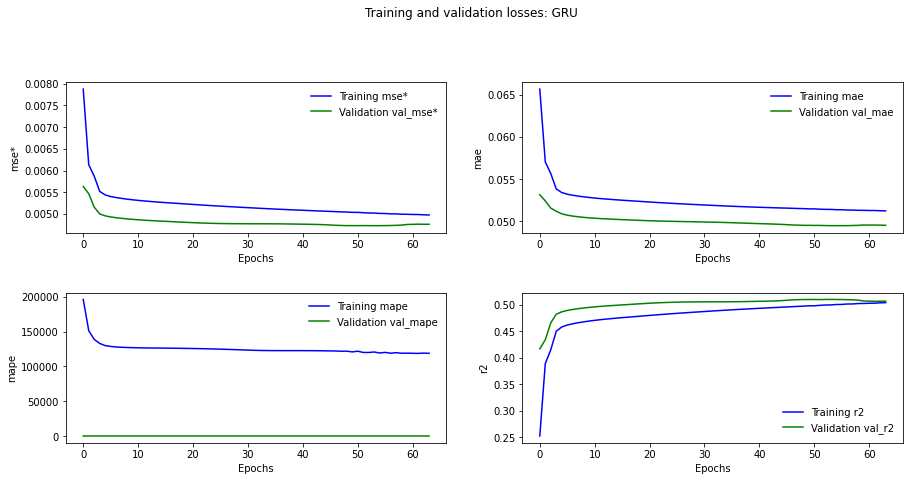

67/67 [==============================] - 0s 5ms/step


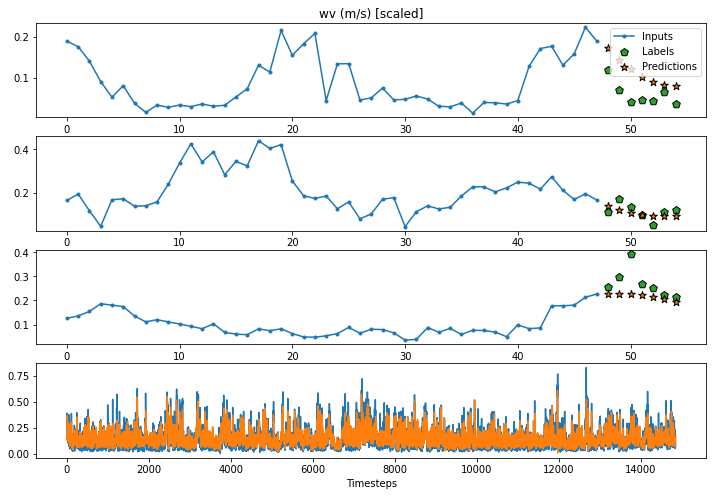

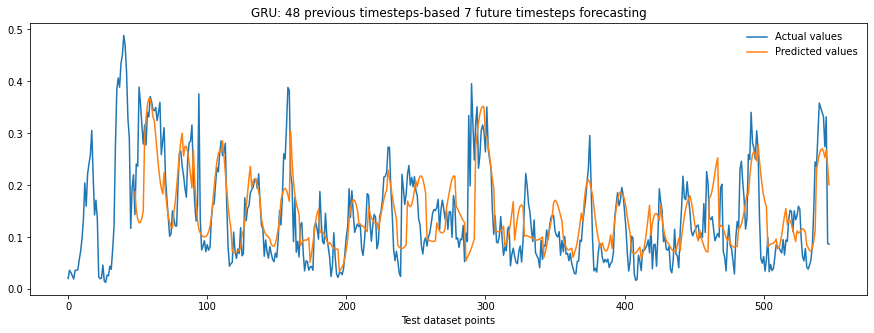

Time taken with the GRU model: 2400.37 sec


In [52]:
dp_gru, mw_gru, mc_gru, train_performance, val_performance, test_performance = run(
    data=weather, modelingclassname=GRU, title="GRU", 
    train_performance=train_performance, val_performance=val_performance, test_performance=test_performance)